
# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第7节 寻找策略最优参数和评分</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载


[abu量化系统github地址](https://github.com/bbfamily/abu) (您的star是我的动力！)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

上一节主要讲解了如何使用abupy中度量模块对回测的结果进行度量，本节将主要讲解使用grid search模块对策略参数寻找最优。

最优参数的意思是比如上一节使用的卖出因子组合使用:

    sell_factors = [
        {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
         'class': AbuFactorAtrNStop},
        {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
        {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
    ]
    
AbuFactorAtrNStop止盈止损策略的止盈阀值是3.0，止损阀值是1.0，那么止盈参数设置成2.0或者止损阀值设置为0.5是不是回测交易效果更好呢，
AbuFactorPreAtrNStop风险控制止损pre_atr_n参数设置的是1.5，如果设置为1.0回测结果将如何，grid search模块对策略寻找最优参数就是要在给定的参数组合范畴内，寻找到策略参数最佳的设置。


首先导入abupy中本节使用的模块：

In [1]:
# 基础库导入
from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


### 1. 参数取值范围


Grid Search实际上是蒙特卡洛方法的一种实现子集，它首先固定了几组参数取值范围，把无限个解问题先缩小到有限个解的问题，然后对排列组合的各个参数组合迭代进行运算，得到最优结果。

既然是在给定参数范围内寻找最优，所以首先要给定一个合理的参数范围，下面首先寻找AbuFactorAtrNStop的参数组合如下所示：

In [2]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak
from abupy import abu, ABuFileUtil, ABuGridHelper, GridSearch, AbuBlockProgress, ABuProgress

stop_win_range = np.arange(2.0, 4.5, 0.5)
stop_loss_range = np.arange(0.5, 2, 0.5)

sell_atr_nstop_factor_grid = {
              'class': [AbuFactorAtrNStop],
              'stop_loss_n'   : stop_loss_range,
              'stop_win_n'   : stop_win_range
         }

print('AbuFactorAtrNStop止盈参数stop_win_n设置范围:{}'.format(stop_win_range))
print('AbuFactorAtrNStop止损参数stop_loss_n设置范围:{}'.format(stop_loss_range))

AbuFactorAtrNStop止盈参数stop_win_n设置范围:[ 2.   2.5  3.   3.5  4. ]
AbuFactorAtrNStop止损参数stop_loss_n设置范围:[ 0.5  1.   1.5]


之前小节构造因子对象的序列使用字典形式装载参数和class，如下所示

    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},

上面sell_atr_nstop_factor_grid使用类似的方法构造字典对象，区别就是所有字典中的元素都变成可迭代的序列了。
   

使用类似的方式设置AbuFactorPreAtrNStop与AbuFactorCloseAtrNStop参数设置范围，如下所示：

In [3]:
close_atr_range = np.arange(1.0, 4.0, 0.5)
pre_atr_range = np.arange(1.0, 3.5, 0.5)

sell_atr_pre_factor_grid = {
              'class': [AbuFactorPreAtrNStop],
              'pre_atr_n' : pre_atr_range
         }

sell_atr_close_factor_grid = {
              'class': [AbuFactorCloseAtrNStop],
              'close_atr_n' : close_atr_range
         }

print('暴跌保护止损参数pre_atr_n设置范围:{}'.format(pre_atr_range))
print('盈利保护止盈参数close_atr_n设置范围:{}'.format(close_atr_range))

暴跌保护止损参数pre_atr_n设置范围:[ 1.   1.5  2.   2.5  3. ]
盈利保护止盈参数close_atr_n设置范围:[ 1.   1.5  2.   2.5  3.   3.5]


在参数参数设置范围确定了的前提下即可以开始对参数进行组合，代码如下所示：

In [4]:
sell_factors_product = ABuGridHelper.gen_factor_grid(
    ABuGridHelper.K_GEN_FACTOR_PARAMS_SELL,
    [sell_atr_nstop_factor_grid, sell_atr_pre_factor_grid, sell_atr_close_factor_grid], need_empty_sell=True)

print('卖出因子参数共有{}种组合方式'.format(len(sell_factors_product)))
print('卖出因子组合0: 形式为{}'.format(sell_factors_product[0]))

卖出因子参数共有477种组合方式
卖出因子组合0: 形式为[{'class': <class 'abupy.FactorSellBu.ABuFactorAtrNStop.AbuFactorAtrNStop'>, 'stop_loss_n': 0.5, 'stop_win_n': 2.0}, {'class': <class 'abupy.FactorSellBu.ABuFactorPreAtrNStop.AbuFactorPreAtrNStop'>, 'pre_atr_n': 1.0}, {'class': <class 'abupy.FactorSellBu.ABuFactorCloseAtrNStop.AbuFactorCloseAtrNStop'>, 'close_atr_n': 1.0}]


上述代码使用ABuGridHelper.gen_factor_grid对参数进行组合，结果共组合出477种包括不同参数的组合，不同因子的组合，也有完全不使用任何因子的组合。

相似方式使用ABuGridHelper生成不同买入参数的因子排列组合, 这里只使用42日、60日作为备选参数。读者可使用类似bk_days = np.arange(20, 130, 10)方式生成更多的买入参数，更可以自己实现其它的买入策略与AbuFactorBuyBreak一同做grid，但是在之后阶段运行Grid Search速度就会越慢。

In [5]:
buy_bk_factor_grid1 = {
    'class': [AbuFactorBuyBreak],
    'xd': [42]
}

buy_bk_factor_grid2 = {
    'class': [AbuFactorBuyBreak],
    'xd': [60]
}

buy_factors_product = ABuGridHelper.gen_factor_grid(
    ABuGridHelper.K_GEN_FACTOR_PARAMS_BUY, [buy_bk_factor_grid1, buy_bk_factor_grid2])

print('买入因子参数共有{}种组合方式'.format(len(buy_factors_product)))
print('买入因子组合形式为{}'.format(buy_factors_product))

买入因子参数共有3种组合方式
买入因子组合形式为[[{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 42}, {'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 60}], [{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 42}], [{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 60}]]


由于只选用42d、60d为参数，所以只有三种排列组合，也就是分别为：

* 只使用42d突破因子
* 只使用60d突破因子
* 同时使用42d、60d突破因子


买入因子有477种组合，卖出因子有3种组合，两者再组合将有477 x 3 = 1431中因子组合

In [6]:
print('组合因子参数数量{}'.format(len(buy_factors_product) * len(sell_factors_product) ))

组合因子参数数量1431


### 2. Grid Search寻找最优参数

下面代码使用abupy中的GridSearch类进行最优参数寻找，从GridSearch类参数可以看到除了buy_factors_product、sell_factors_product外，还有stock_pickers_product（选股因子排列组合）本例没有用到，读者可自行尝试。

In [7]:
read_cash = 1000000
choice_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG',
                  'usTSLA', 'usWUBA', 'usVIPS']
grid_search = GridSearch(read_cash, choice_symbols,
                         buy_factors_product=buy_factors_product,
                         sell_factors_product=sell_factors_product)

下面开始通过fit函数开始寻找最优，第一次运行select：run gird search，然后点击run select，如果已经运行过可select：load score cache直接从缓存数据读取

备注：如果第一次运行选择run gird search下面的运行耗时大约1小时多，建议电脑空闲时运行

In [8]:
scores = None
score_tuple_array = None

def run_grid_search():
    global scores, score_tuple_array
    # 运行GridSearch n_jobs=-1启动cpu个数的进程数
    scores, score_tuple_array = grid_search.fit(n_jobs=-1)
    # 运行完成输出的score_tuple_array可以使用dump_pickle保存在本地，以方便之后使用
    ABuFileUtil.dump_pickle(score_tuple_array, '../gen/score_tuple_array')

def load_score_cache():
    """有本地数据score_tuple_array后，即可以从本地缓存读取score_tuple_array"""
    global scores, score_tuple_array
    
    with AbuBlockProgress('load score cache'):
        score_tuple_array = ABuFileUtil.load_pickle('../gen/score_tuple_array')
        if not hasattr(grid_search, 'best_score_tuple_grid'):
            # load_pickle的grid_search没有赋予best_score_tuple_grid，这里补上
            from abupy import make_scorer, WrsmScorer
            scores = make_scorer(score_tuple_array, WrsmScorer)
            grid_search.best_score_tuple_grid = score_tuple_array[scores.index[-1]]
        print('load complete!')
        
def select(select):
    if select == 'run gird search':
        run_grid_search()
    else: # load score cache
        load_score_cache()

_ = ipywidgets.interact_manual(select, select=['run gird search', 'load score cache'])

下面使用type查看返回的score_tuple_array类型为list，score_tuple_array中的元素类型为AbuScoreTuple：

In [9]:
type(score_tuple_array), type(score_tuple_array[0])

(list, abupy.MetricsBu.ABuMetricsScore.AbuScoreTuple)

上面说过组合数量477 x 3 = 1431中因子组合：

最终的评分结果也应该scores是有1431种，下面开始验证：

In [10]:
print('最终评分结果数量{}'.format(len(scores)))

最终评分结果数量1431


grid_search中保存了得到分数最高的对象best_score_tuple_grid，可以利用它直接用AbuMetricsBase可视化最优参数结果，如图：

买入后卖出的交易数量:38
买入后尚未卖出的交易数量:2
胜率:60.5263%
平均获利期望:13.4462%
平均亏损期望:-6.0647%
盈亏比:3.2382
策略收益: 31.5812%
基准收益: 15.0841%
策略年化收益: 15.7906%
基准年化收益: 7.5420%
策略买入成交比例:100.0000%
策略资金利用率比例:18.0478%
策略共执行504个交易日


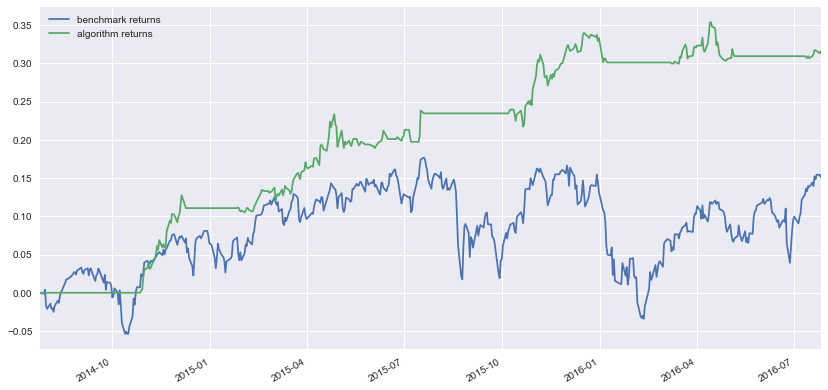

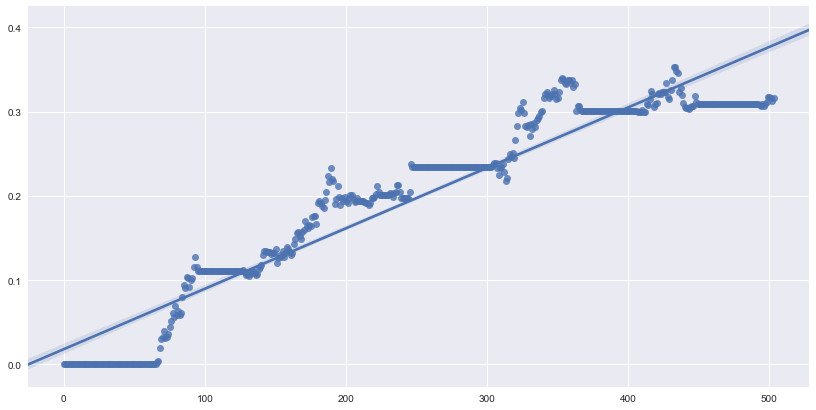

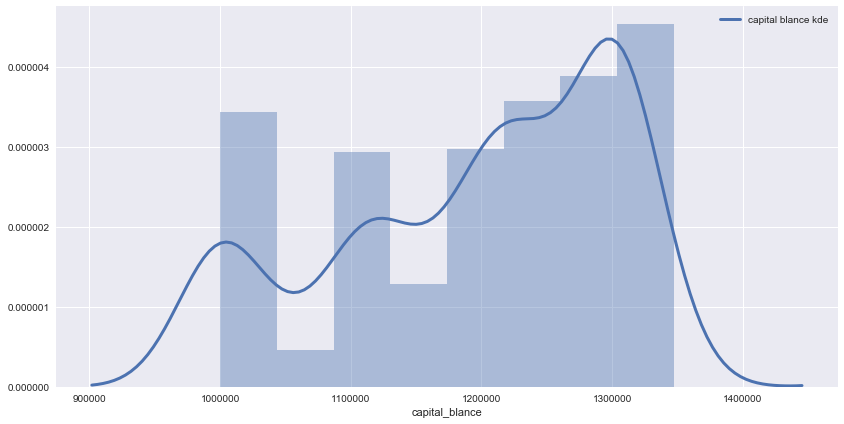

alpha阿尔法:0.1310
beta贝塔:0.1100
Information信息比率:0.0210
策略Sharpe夏普比率: 1.8907
基准Sharpe夏普比率: 0.5012
策略波动率Volatility: 0.0742
基准波动率Volatility: 0.1689


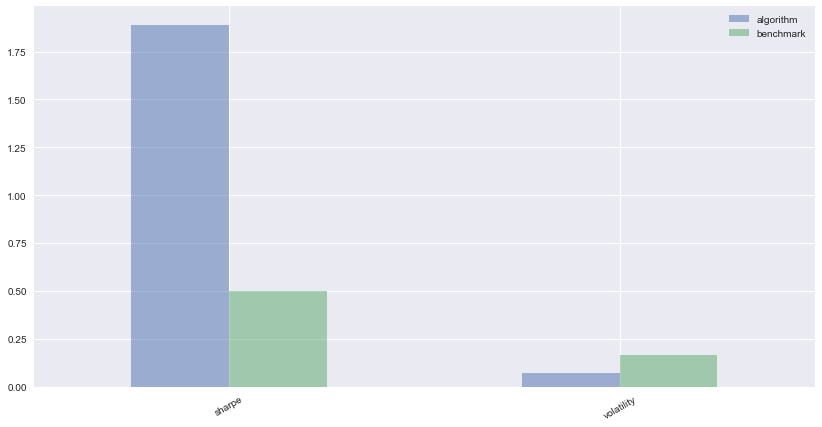

In [13]:
from abupy import AbuMetricsBase
best_score_tuple_grid = grid_search.best_score_tuple_grid
AbuMetricsBase.show_general(best_score_tuple_grid.orders_pd, best_score_tuple_grid.action_pd,
                                        best_score_tuple_grid.capital, best_score_tuple_grid.benchmark)

### 3. 度量结果的评分

读者可能会有的疑问1：哪里来的分数，怎么评定的分数。

在GridSearch类 fit()函数中可以看到第二个参数score_class需要一个判分类，在fit()中最后几行使用ABuMetricsScore.make_scorer()函数将所有返回的结果score_tuple_array使用判分类WrsmScorer对结果打分数。

打分数实现的基本思路为：如果想根据sharpe值的结果来对最优参数下判断，但是sharpe值多大可以判定为100分？多大可以判断为50分呢？我们无法确定，所以将所有sharpe结果排序，由于sharpe值越大越好，所以排序结果对应分数由0至1，这样就可以得到某一个具体参数组合的sharpe值的分数。这样的话使用多个评分标准， 比如这里使用'win_rate'、 'returns'、 'sharpe'、'max_drawdown'四种，就可以分别计算出某个参数组合对应的度量指标评分，再乘以分配给它们的权重就可以得到最终结果分数。


具体请阅读GridSearch.fit，AbuBaseScorer，WrsmScorer源代码实现

如下代码我们实例化一个评分类WrsmScorer，它的参数为之前GridSearch返回的score_tuple_array对象：

In [12]:
from abupy import WrsmScorer
scorer = WrsmScorer(score_tuple_array)

如下可以看到scorer中的score_pd是由评分的度量指标数值，以及这个具体数据对应项所得的分数组成：

In [14]:
scorer.fit_score()
scorer.score_pd.tail()

,win_rate,returns,sharpe,max_drawdown,score_win_rate,score_returns,score_sharpe,score_max_drawdown,score
677,0.6053,0.2989,1.6663,-0.0479,0.949,0.9308,0.9860,0.9776,0.9608
695,0.6053,0.2966,1.6902,-0.0407,0.949,0.9301,0.9895,0.9972,0.9664
815,0.6053,0.3090,1.8297,-0.0462,0.949,0.9406,0.9979,0.9839,0.9678
671,0.6053,0.3107,1.7337,-0.0424,0.949,0.9413,0.9923,0.9958,0.9696
665,0.6053,0.3158,1.8907,-0.0375,0.949,0.9469,1.0000,1.0000,0.9740


由于AbuBaseScorer 中fit_score()函数的实现只是对score_pd的'score'项进行排序后返回score，这样最终的结果为分数及对应score_tuple_array的序列号，从上面输出可以看出665为最优参数序号。

### 4. 不同权重的评分

读者可能会有的疑问2：为什么从度量可视化看到的这个最优的投资回报还没有上一节的那个回测高？

因为由于默认的WrsmScorer使用：胜率、sharpe、投资回报、最大回撤这四个因素，综合评定策略的分数，并且类GridSearch默认为四项等权重评分，我们下面可以仍然使用WrsmScorer但是通过调整权重来达到各种评定效果。

In [17]:
# 实例化WrsmScorer，参数weights，只有第二项为1，其他都是0，
# 代表只考虑投资回报来评分
scorer = WrsmScorer(score_tuple_array, weights=[0, 1, 0, 0])
# 返回排序后的队列
scorer_returns_max = scorer.fit_score()
# 因为是倒序排序，所以index最后一个为最优参数
best_score_tuple_grid = score_tuple_array[scorer_returns_max.index[-1]]
# 由于篇幅，最优结果只打印文字信息
AbuMetricsBase.show_general(best_score_tuple_grid.orders_pd,
                            best_score_tuple_grid.action_pd,
                            best_score_tuple_grid.capital,
                            best_score_tuple_grid.benchmark,
                            only_info=True)

买入后卖出的交易数量:51
买入后尚未卖出的交易数量:19
胜率:82.3529%
平均获利期望:16.2075%
平均亏损期望:-7.6414%
盈亏比:8.8162
策略收益: 49.7671%
基准收益: 15.0841%
策略年化收益: 24.8835%
基准年化收益: 7.5420%
策略买入成交比例:62.8571%
策略资金利用率比例:41.3748%
策略共执行504个交易日
alpha阿尔法:0.1810
beta贝塔:0.3710
Information信息比率:0.0485
策略Sharpe夏普比率: 1.4955
基准Sharpe夏普比率: 0.5012
策略波动率Volatility: 0.1420
基准波动率Volatility: 0.1689


可以看到只考虑投资回报来评分的话，上面策略收益: 50.44%为最高。

下面通过best_score_tuple_grid.buy_factors，best_score_tuple_grid.sell_factors看一下这个收益的买入因子参数、卖出因子参数，如下所示，可以发现它的因子参数组合与我在上一节开始使用的参数是一摸一样的。

In [18]:
best_score_tuple_grid.buy_factors, best_score_tuple_grid.sell_factors

([{'class': abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak, 'xd': 42},
  {'class': abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak, 'xd': 60}],
 [{'class': abupy.FactorSellBu.ABuFactorCloseAtrNStop.AbuFactorCloseAtrNStop,
   'close_atr_n': 1.5}])

下面看一下只考虑胜率来评分的结果，从结果可以看到虽然胜率达到了85%以上，但是收益并不高：

买入后卖出的交易数量:21
买入后尚未卖出的交易数量:9
胜率:85.7143%
平均获利期望:19.0903%
平均亏损期望:-9.2893%
盈亏比:9.4105
策略收益: 21.5035%
基准收益: 15.0841%
策略年化收益: 10.7518%
基准年化收益: 7.5420%
策略买入成交比例:86.6667%
策略资金利用率比例:44.3042%
策略共执行504个交易日


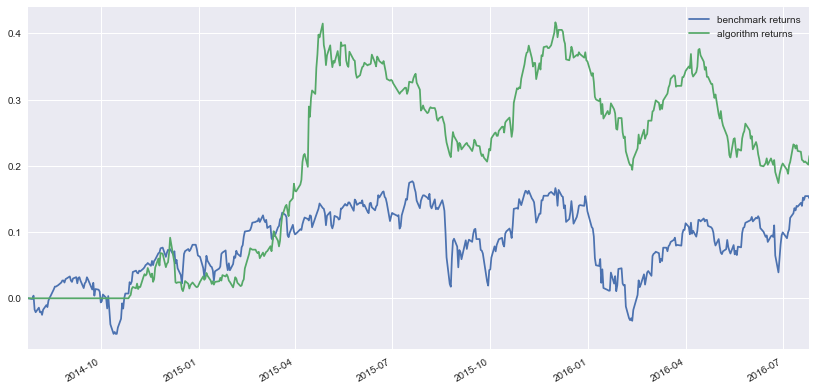

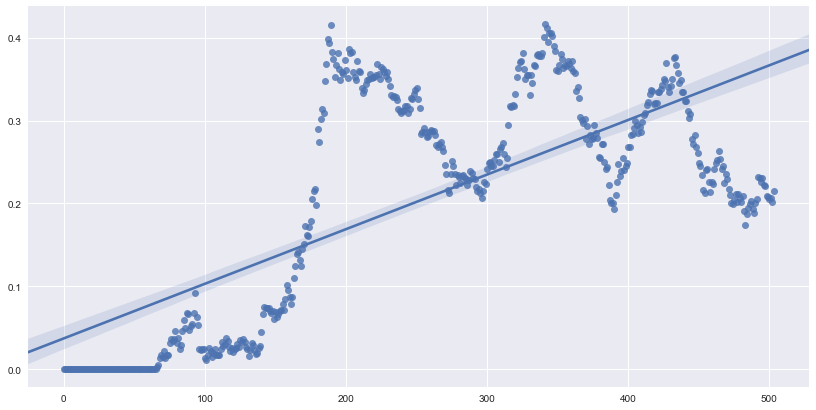

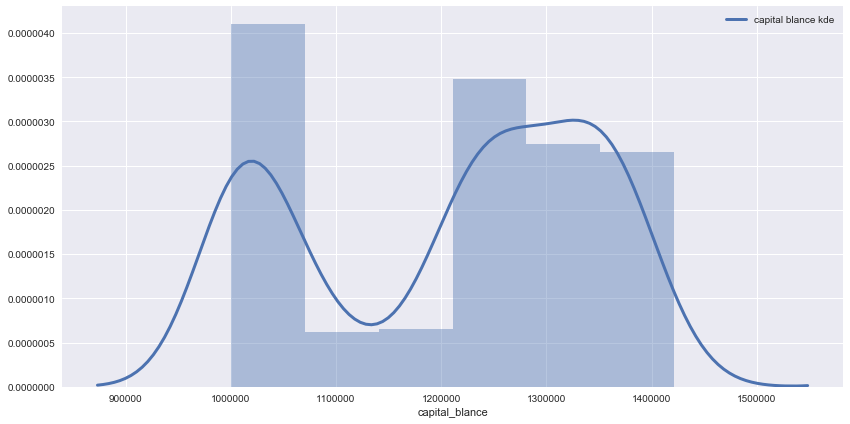

alpha阿尔法:0.0724
beta贝塔:0.4226
Information信息比率:0.0092
策略Sharpe夏普比率: 0.7392
基准Sharpe夏普比率: 0.5012
策略波动率Volatility: 0.1464
基准波动率Volatility: 0.1689


([{'class': abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak, 'xd': 60}],
 [{'class': abupy.FactorSellBu.ABuFactorCloseAtrNStop.AbuFactorCloseAtrNStop,
   'close_atr_n': 1.5}])

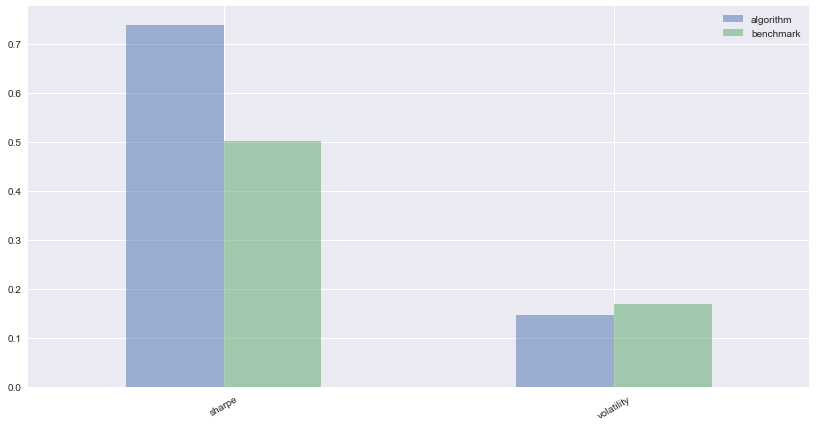

In [19]:
# 只有第一项为1，其他都是0代表只考虑胜率来评分
scorer = WrsmScorer(score_tuple_array, weights=[1, 0, 0, 0])
# 返回按照评分排序后的队列
scorer_returns_max = scorer.fit_score()
# index[-1]为最优参数序号
best_score_tuple_grid = score_tuple_array[scorer_returns_max.index[-1]]
AbuMetricsBase.show_general(best_score_tuple_grid.orders_pd,
                            best_score_tuple_grid.action_pd,
                            best_score_tuple_grid.capital,
                            best_score_tuple_grid.benchmark,
                            only_info=False)

# 最后打印出只考虑胜率下最优结果使用的买入策略和卖出策略
best_score_tuple_grid.buy_factors, best_score_tuple_grid.sell_factors

从输出可以看到买入策略只使用60天突破买入作为买入信号，卖出只以保护利润的止盈ABuFactorCloseAtrNStop发出卖出信号，其实这种策略就是没有止损的策略。很像大多数普通交易者的交易模式，亏损了的交易不卖出，持有直到可以再次盈利为。这样的方式投资者的胜率非常高，我之前看过几个朋友的交易账户，发现他们交易的胜率非常高，但他们的账户最终都是亏损的，我认为交易中最虚幻的就是胜率，但是大多数人追求的反而是胜率。如果说股票市场最终的投资结果90%的人将亏损收场话，那我相信这90%的人胜率大多数都为超过50%甚至更高，那么如果我们想最终战胜市场的话，我们的有效投资策略是不是应该是胜率低于50%的呢？

### 5. 自定义评分类的实现

上面的评分全部都是使用abupy中内置的WrsmScorer做为评分类，其从四个维度：胜率、sharpe、投资回报、最大回撤综合评定策略的分数，通过调整权重来达到各种评定效果，但是如果用户想要从其它的维度来综合评分的话就需要自定义评分类。

上一节中最后示例扩展自定义度量类中编写了MetricsDemo度量类，它扩展了AbuMetricsBase度量类，添加了交易手续费相关度量值，以及可视化方法
，下面的示例编写评分类将使用手续费做为一个度量维度对grid结果进行评分，代码如下所示:

In [15]:
from abupy import AbuBaseScorer

class DemoScorer(AbuBaseScorer):
    def _init_self_begin(self, *arg, **kwargs):
        """胜率，策略收益，手续费组成select_score_func"""

        self.select_score_func = lambda metrics: [metrics.win_rate, metrics.algorithm_period_returns,
                                                  metrics.commission_sum]
        self.columns_name = ['win_rate', 'returns', 'commission']
        self.weights_cnt = len(self.columns_name)

    def _init_self_end(self, *arg, **kwargs):
        """
        _init_self_end这里一般的任务是将score_pd中需要反转的反转，默认是数据越大越好，有些是越小越好，
        类似make_scorer(xxx, greater_is_better=True)中的参数greater_is_better的作用：

                            sign = 1 if greater_is_better else -1
        """
        self.score_pd['commission'] = -self.score_pd['commission']

上面的代码DemoScorer即实现了自定义评分类：

1. 自定义评分类需要继承AbuBaseScorer
2. 自定义评分类需要实现_init_self_begin，声明自己要度量metrics中的那些度量值
3. 自定义评分类需要实现_init_self_end，在这里将需要反转结果的度量值进行反转

本例_init_self_end中使用：

    self.score_pd['commission'] = -self.score_pd['commission']
    
将手续费数值进行反转，因为本例度量的标准是手续费的花销越小代表结果越好，所以需要在_init_self_end中将手续费这一列变成负数。

下面构建DemoScorer，注意传递了关键字参数metrics_class，使用MetricsDemo，默认不传递metrics_class将使用AbuMetricsBase做为度量类提供度量值，但是DemoScorer中需要使用metrics.commission_sum，所以这里必须使用MetricsDemo，代码如下所示：

备注：已将MetricsDemo做为abupy内置策略示例因子在项目中，所以本节不重复编写，直接从abupy中import，如下所示

In [17]:
from abupy import MetricsDemo

scorer = DemoScorer(score_tuple_array, metrics_class=MetricsDemo)
# 返回按照评分排序后的队列
scorer_returns_max = scorer.fit_score()
scorer.score_pd.sort_values(by='score_commission').tail()

,win_rate,returns,commission,score_win_rate,score_returns,score_commission,score
248,0.0000,-0.0339,-1540.17,0.0007,0.0797,0.9972,0.3592
182,0.3333,-0.1268,-1415.37,0.1538,0.0084,0.9979,0.3867
183,0.2000,-0.0919,-1284.72,0.0224,0.0245,0.9986,0.3485
184,0.2000,-0.0563,-1284.72,0.0224,0.0524,0.9986,0.3578
6,0.0000,-0.0821,-1179.97,0.0007,0.0322,1.0000,0.3443


上面代码使用DemoScorer对grid的结果进行评分，从score_pd.tail()中最后一行可以看到commission=-1179.97, 即手续费总开销为1179.97的score_commission评分结果在手续费评分结果中是满分1

In [19]:
scorer.score_pd.sort_values(by='score_commission').head()

,win_rate,returns,commission,score_win_rate,score_returns,score_commission,score
1105,0.4478,0.2201,-5008.43,0.5224,0.8315,0.0000,0.4513
1135,0.4478,0.2208,-5008.43,0.5224,0.8322,0.0000,0.4515
1075,0.4478,0.1304,-4975.82,0.5224,0.5937,0.0021,0.3727
1165,0.4478,0.1369,-4975.82,0.5224,0.6224,0.0021,0.3823
1195,0.4478,0.1208,-4975.82,0.5224,0.5650,0.0021,0.3632


从score_pd.head()中可以看到手续费开销越大的在手续费分数score_commission这一栏中的得分结果就越低，
可想而知如果使用：

    scorer = DemoScorer(score_tuple_array, metrics_class=MetricsDemo, weights=[0, 0, 1])
       
将评分权重都放在手续费的开销上，那么评分的结果最后的即是不怎么进行买入交易，或者买入后不进行卖出交易的参数组合了，读者可自行尝试。

关于评分类的更多细节请自行阅读源AbuBaseScorer

小结：对于交易系统的优化，最优参数的选择问题，首先我们要明确所有的参数拟合都是基于历史数据的，即拟合一组最优参数使其对特定历史或者特定一些股票的回测结果趋于完美的实际意义并不大，有时反而适得其反，但是大粒度的统计意义依然具备。比如上面使用的一些因子的参数你设置为100或者其他不靠谱的数那肯定是不合适的，在统计范围内来限制参数的有限个解是有意义的，但是真实的最优参数却是不存在的，不要在最优参数上陷入误区，适可而止，掌握好度，是做好每一件事情的关键。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)

更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

如有任何问题也可在公众号中联系我的个人微信号。

![](./image/qrcode.jpg)